Fastai(PyTorch 기반 라이브러리)를 이용해 미리 학습된 모델 적용

참고 : 
https://captain-tak.tistory.com/58

https://velog.io/@mn99134/%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%B6%84%EB%A5%98-%EB%AA%A8%EB%8D%B8

https://medium.com/unpackai/animal-classsification-using-fast-ai-9bad05613bc8

In [1]:
# 구글 드라이브 연결 테스트 셋 https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import zipfile as zf
files = zf.ZipFile("/gdrive/MyDrive/Colab Notebooks/onlyimagedata.zip",'r') # 기존 ZIP 압축 파일의 자료 읽기
files.extractall()
files.close()

In [3]:
import os
os.listdir(os.path.join(os.getcwd(), "data")) # 항목이름 리스트 반환

['plastic', 'paper', 'can', 'styro', 'vin', 'pet']

In [6]:
!pip install split-folders 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# 각 라벨마다 train, test, val 파일 생성 및 데이터 나누기 (80% 10% 10%)
import splitfolders

os.mkdir("/content/data_new")
splitfolders.ratio('/content/data', output="/content/data_new", seed=77, ratio=(0.8, 0.1, 0.1))
#shutil.rmtree("data") # 기존 데이터셋 파일일 삭제

Copying files: 60000 files [00:22, 2623.96 files/s]


In [8]:
!pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from fastai.vision.all import *

path = Path(os.getcwd())/"data_new"
data = ImageDataLoaders.from_folder(path, test="test", valid='val', bs=16) # 파일을 담은 리스트 생성

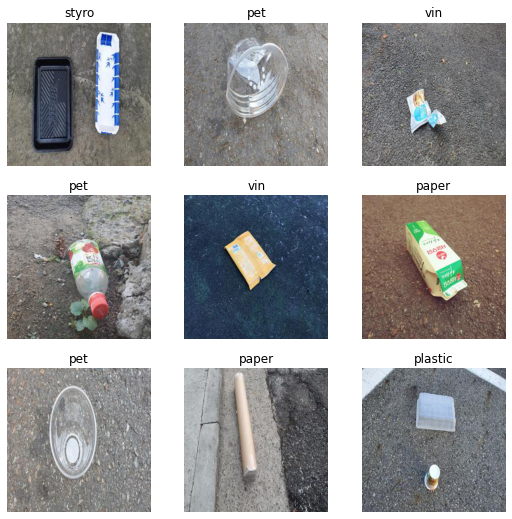

In [10]:
data.show_batch() #랜덤하게 데이터 보기

In [11]:
# train과 valid 데이터 개수 확인
print(len(data.train_ds), len(data.valid_ds))

48000 6000


In [12]:
#defaults.callbacks[1] = Recorder(train_metrics=True)
#defaults.callbacks
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])
# fastai에서 이미 학습된 모델을 가져온다. 모델링은 resnet34, 평가지표는 에러율(error_rate) 

/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pt

  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0010232930071651936)

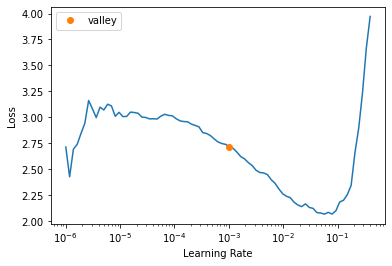

In [13]:
learn.lr_find(start_lr=1e-6, end_lr=1e1) # lr_find = 가장 적합한 lr을 찾아주는 메서드

In [14]:
learn.fine_tune(10, base_lr=2e-3) 
# fine_tune(미세조정): 추가 에포크 동안 사전 학습된 모델을 새로운 데이터셋에 적응시키는 메소드 #lr 대략 0.002 (보통은 3e-3이 좋다고 함)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.539363,0.368840,0.137167,0.862833,04:32


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.290150,0.196794,0.068500,0.931500,06:09
1,0.275391,0.234667,0.082500,0.917500,06:06
2,0.222497,0.214308,0.073000,0.927000,06:05
3,0.140520,0.186591,0.057833,0.942167,06:04
4,0.107141,0.194208,0.058833,0.941167,06:05
5,0.050295,0.186297,0.053667,0.946333,06:04
6,0.022922,0.187939,0.045333,0.954667,06:04
7,0.012307,0.203151,0.043000,0.957000,06:09
8,0.001872,0.199849,0.039000,0.961000,06:06
9,0.000382,0.201334,0.038667,0.961333,06:13


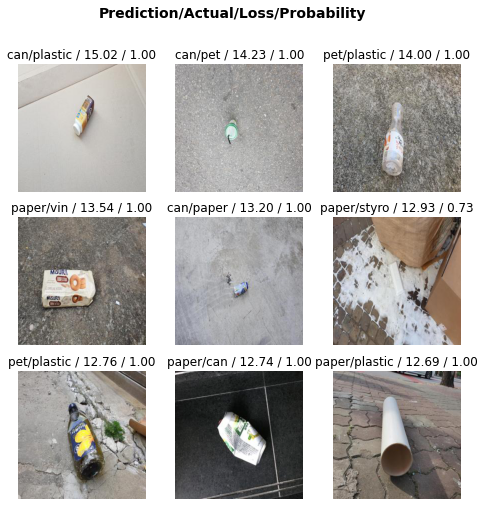

In [15]:
# loss 값이 큰 것들 순서대로 표시
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(8,8))

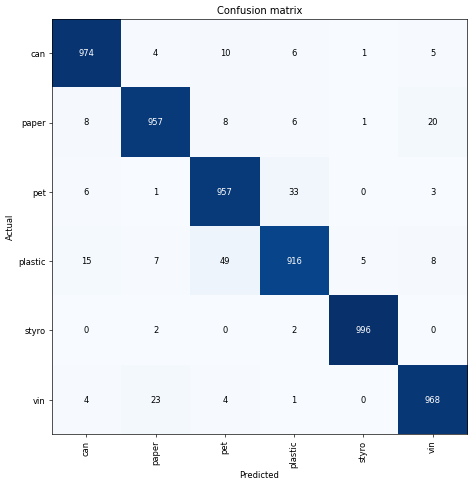

In [16]:
# confusion matrix 그려보기
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [17]:
# 가장 혼동되는 조합 정렬
interp.most_confused()

[('plastic', 'pet', 49),
 ('pet', 'plastic', 33),
 ('vin', 'paper', 23),
 ('paper', 'vin', 20),
 ('plastic', 'can', 15),
 ('can', 'pet', 10),
 ('paper', 'can', 8),
 ('paper', 'pet', 8),
 ('plastic', 'vin', 8),
 ('plastic', 'paper', 7),
 ('can', 'plastic', 6),
 ('paper', 'plastic', 6),
 ('pet', 'can', 6),
 ('can', 'vin', 5),
 ('plastic', 'styro', 5),
 ('can', 'paper', 4),
 ('vin', 'can', 4),
 ('vin', 'pet', 4),
 ('pet', 'vin', 3),
 ('styro', 'paper', 2),
 ('styro', 'plastic', 2),
 ('can', 'styro', 1),
 ('paper', 'styro', 1),
 ('pet', 'paper', 1),
 ('vin', 'plastic', 1)]

In [31]:
model_file_name = 'model_new'

#learn.save(model_file_name) # 모델 저장
#learn.load(model_file_name) # 모델 로드

Path('/content/data_new/models/model_new.pth')

In [28]:
preds,y, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.9613333344459534 %.
